In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


---
## Code copied from repo

In [2]:
finetune_wo_infodrop = True

def random_sample(prob, sampling_num):
    """ Randomly sample from probability map prob"""
    batch_size, channels, h, w = prob.shape
    return torch.multinomial((prob.view(batch_size * channels, -1) + 1e-8), sampling_num, replacement=True)

class Info_Dropout(nn.Module):
    def __init__(self, indim, outdim, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, if_pool=False, pool_kernel_size=2, pool_stride=None,
                 pool_padding=0, pool_dilation=1):
        super(Info_Dropout, self).__init__()
        
        if groups != 1:
            raise ValueError('InfoDropout only supports groups=1')

        self.indim = indim
        self.outdim = outdim
        self.if_pool = if_pool
        self.drop_rate = 0.1
        self.temperature = 0.5
        self.band_width = 1.0
        self.radius = 3

        self.patch_sampling_num = 9

        self.all_one_conv_indim_wise = nn.Conv2d(self.patch_sampling_num, self.patch_sampling_num,
                                                 kernel_size=kernel_size, stride=stride, padding=0, dilation=dilation,
                                                 groups=self.patch_sampling_num, bias=False)
        
        self.all_one_conv_indim_wise.weight.data = torch.ones_like(self.all_one_conv_indim_wise.weight, dtype=torch.float)
        self.all_one_conv_indim_wise.weight.requires_grad = False

        self.all_one_conv_radius_wise = nn.Conv2d(self.patch_sampling_num, outdim, kernel_size=1, padding=0, bias=False)
        self.all_one_conv_radius_wise.weight.data = torch.ones_like(self.all_one_conv_radius_wise.weight, dtype=torch.float)
        self.all_one_conv_radius_wise.weight.requires_grad = False


        if if_pool:
            self.pool = nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding, pool_dilation)

        self.padder = nn.ConstantPad2d((padding + self.radius, padding + self.radius + 1,
                                         padding + self.radius, padding + self.radius + 1), 0)

    def initialize_parameters(self):
        self.all_one_conv_indim_wise.weight.data = torch.ones_like(self.all_one_conv_indim_wise.weight, dtype=torch.float)
        self.all_one_conv_indim_wise.weight.requires_grad = False

        self.all_one_conv_radius_wise.weight.data = torch.ones_like(self.all_one_conv_radius_wise.weight, dtype=torch.float)
        self.all_one_conv_radius_wise.weight.requires_grad = False


    def forward(self, x_old, x):
        if finetune_wo_infodrop:
            return x
        
        with torch.no_grad():
            distances = []
            padded_x_old = self.padder(x_old)
            
            sampled_i = [int(val) for val in torch.randint(-self.radius, self.radius + 1, size=(self.patch_sampling_num,)).tolist()]
            sampled_j = [int(val) for val in torch.randint(-self.radius, self.radius + 1, size=(self.patch_sampling_num,)).tolist()]
            
            for i, j in zip(sampled_i, sampled_j):
                tmp = padded_x_old[:, :, self.radius: -self.radius - 1, self.radius: -self.radius - 1] - \
                      padded_x_old[:, :, self.radius + i: -self.radius - 1 + i,
                      self.radius + j: -self.radius - 1 + j]
                      
                      
                distances.append(tmp.clone())
                
            distance = torch.cat(distances, dim=1)
            batch_size, _, h_dis, w_dis = distance.shape
            distance = (distance**2).view(-1, self.indim, h_dis, w_dis).sum(dim=1).view(batch_size, -1, h_dis, w_dis)
            distance = self.all_one_conv_indim_wise(distance)
            distance = torch.exp(
                -distance / distance.mean() / 2 / self.band_width ** 2)  # using mean of distance to normalize
            prob = (self.all_one_conv_radius_wise(distance) / self.patch_sampling_num) ** (1 / self.temperature)

            if self.if_pool:
                prob = -self.pool(-prob)  # min pooling of probability
            prob /= prob.sum(dim=(-2, -1), keepdim=True)


            batch_size, channels, h, w = x.shape

            random_choice = random_sample(prob, sampling_num=int(self.drop_rate * h * w))
            random_mask = torch.ones((batch_size * channels, h * w), device='cuda:0')
            random_mask[torch.arange(batch_size * channels, device='cuda:0').view(-1, 1), random_choice] = 0

        return x * random_mask.view(x.shape)

---

## Simple neural net with infodropout

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.info_dropout = Info_Dropout(32, 64, 3) 
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x1 = nn.ReLU()(self.conv1(x))
        x2 = nn.ReLU()(self.conv2(x1))
        x2_dropped = self.info_dropout(x1, x2) 
        x2_pooled = nn.MaxPool2d(2)(x2_dropped)
        x_flatten = torch.flatten(x2_pooled, 1)
        x_fc1 = nn.ReLU()(self.fc1(x_flatten))
        return nn.LogSoftmax(dim=1)(self.fc2(x_fc1))

---
## custom data class

In [4]:
import numpy as np
from torchvision import datasets
import torch

class CustomMnist(datasets.MNIST):
    def __init__(self, num_classes=6, stripe_thickness=1, stripe_distance=3, vertical_stripe_thickness=1, vertical_stripe_distance=3, *args, **kwargs):
        super(CustomMnist, self).__init__(*args, **kwargs)
        
        # Set class attributes from the provided parameters
        self.num_classes = num_classes
        self.stripe_thickness = stripe_thickness
        self.stripe_distance = stripe_distance
        self.vertical_stripe_thickness = vertical_stripe_thickness
        self.vertical_stripe_distance = vertical_stripe_distance

        # Determine if the dataset is in training or testing mode
        if self.train:
            mask = self.train_labels <= self.num_classes
            self.train_data = self.train_data[mask]
            self.train_labels = self.train_labels[mask]
        else:
            mask = self.test_labels <= self.num_classes
            self.test_data = self.test_data[mask]
            self.test_labels = self.test_labels[mask]
            
        # Add texture to the images
        self.add_texture()

    def add_texture(self):
        # Generate a simple random noise
        noise = (np.random.rand(28, 28) * 255).astype(np.uint8)

        # Create a striped mask
        stripe_mask = np.zeros((28, 28), dtype=np.uint8)
        
        # Horizontal stripes
        for i in range(self.stripe_thickness):
            stripe_mask[i::(self.stripe_thickness + self.stripe_distance), :] = 1 

        # Vertical stripes
        for i in range(self.vertical_stripe_thickness):
            stripe_mask[:, i::(self.vertical_stripe_thickness + self.vertical_stripe_distance)] = 1 

        # Apply mask to the noise
        texture = noise * stripe_mask

        if self.train:
            for i in range(len(self.train_data)):
                blended_image = self.blend(self.train_data[i].numpy(), texture)
                self.train_data[i] = torch.ByteTensor(blended_image)
        else:
            for i in range(len(self.test_data)):
                blended_image = self.blend(self.test_data[i].numpy(), texture)
                self.test_data[i] = torch.ByteTensor(blended_image)
    
    @staticmethod
    def blend(image, texture):
        # Simple blending: weighted sum
        return np.clip(image + texture, 0, 255).astype(np.uint8)


---
## train and test functions

In [5]:
def train(model, train_loader, optimizer, criterion, device, epochs):
    """
    Train the model.
    
    Parameters:
    - model: The neural network model.
    - train_loader: DataLoader for the training dataset.
    - optimizer: The optimization algorithm.
    - criterion: The loss function.
    - device: The device (e.g., 'cuda' or 'cpu') to run the model on.
    - epochs: Number of epochs to train.
    """
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}")


def test(model, test_loader, criterion, device):
    """
    Test the model.

    Parameters:
    - model: The neural network model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function.
    - device: The device (e.g., 'cuda' or 'cpu') to run the model on.
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

---

Processing...
Done!


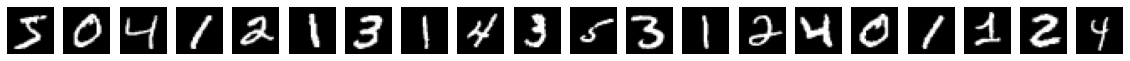

In [6]:
# Plot images with texture
dataset = CustomMnist(root='./data', train=True, download=True, num_classes=5, stripe_thickness=0, vertical_stripe_thickness=0)
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(1, 20, i + 1)
    plt.imshow(dataset[i][0], cmap='gray')
    plt.axis('off')
plt.show()

You can play around with the parameters here, for now noise can be added and adjusted using stripe_thickness, stripe_distance, vertical_stripe_thickness, vertical_stripe_distance and the number of classes included can be changed with num_classes

In [7]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# False for finetuning WITH InfoDropout
finetune_wo_infodrop = False

# Download and load data
transform = transforms.ToTensor()

train_dataset = CustomMnist(root='./data', train=True, transform=transform, num_classes=5, stripe_thickness=2, stripe_distance=4)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomMnist(root='./data', train=False, transform=transform, num_classes=5, stripe_thickness=2, stripe_distance=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Model, loss, and optimizer
model = SimpleCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [8]:
train(model, train_loader, optimizer, criterion, DEVICE, EPOCHS)

Epoch: 1, Batch: 0, Loss: 2.2825
Epoch: 1, Batch: 100, Loss: 0.2548
Epoch: 1, Batch: 200, Loss: 0.0932
Epoch: 1, Batch: 300, Loss: 0.1537
Epoch: 1, Batch: 400, Loss: 0.1422
Epoch: 1, Batch: 500, Loss: 0.0792
Epoch: 2, Batch: 0, Loss: 0.0170
Epoch: 2, Batch: 100, Loss: 0.0238
Epoch: 2, Batch: 200, Loss: 0.0506
Epoch: 2, Batch: 300, Loss: 0.0653
Epoch: 2, Batch: 400, Loss: 0.1136
Epoch: 2, Batch: 500, Loss: 0.0371
Epoch: 3, Batch: 0, Loss: 0.0146
Epoch: 3, Batch: 100, Loss: 0.1424
Epoch: 3, Batch: 200, Loss: 0.0211
Epoch: 3, Batch: 300, Loss: 0.0550
Epoch: 3, Batch: 400, Loss: 0.0748
Epoch: 3, Batch: 500, Loss: 0.0359
Epoch: 4, Batch: 0, Loss: 0.0346
Epoch: 4, Batch: 100, Loss: 0.1463
Epoch: 4, Batch: 200, Loss: 0.1281
Epoch: 4, Batch: 300, Loss: 0.0681
Epoch: 4, Batch: 400, Loss: 0.0121
Epoch: 4, Batch: 500, Loss: 0.0737
Epoch: 5, Batch: 0, Loss: 0.0689
Epoch: 5, Batch: 100, Loss: 0.1324
Epoch: 5, Batch: 200, Loss: 0.0178
Epoch: 5, Batch: 300, Loss: 0.0187
Epoch: 5, Batch: 400, Loss: 0.

In [9]:
test(model, test_loader, criterion, DEVICE)



Test set: Average loss: 0.0010, Accuracy: 5901/6031 (98%)

